<a href="https://colab.research.google.com/github/hahaws666/-/blob/main/ligthgbmonrotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import yfinance as yf
import re
import matplotlib.pyplot as plt

def download_data(symbol, start_date, end_date):
    return yf.download(symbol, start=start_date, end=end_date)

def calculate_rsi(prices, window):
    delta = prices.diff(1)
    gain = delta.clip(lower=0).rolling(window=window).mean()
    loss = -delta.clip(upper=0).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def sanitize_feature_names(df):
    df.columns = [re.sub(r'[^A-Za-z0-9_]+', '', str(col)) for col in df.columns]
    return df

def compute_features(data_etf, data_sp500):
    df = data_etf[['Adj Close']].rename(columns={"Adj Close": "Price"}).copy()
    df['sp500price'] = data_sp500['Adj Close']

    for i in range(1, 6):
        df[f'Return_{i}'] = df['Price'].pct_change(i)

    df['RSI_6'] = calculate_rsi(df['Price'], 6)
    df['RSI_12'] = calculate_rsi(df['Price'], 12)
    df['RSI_24'] = calculate_rsi(df['Price'], 24)

    for ma in [20, 50, 100]:
        df[f'MA{ma}_Price'] = df['Price'].rolling(window=ma).mean() / df['Price']


    sp500_returns = data_sp500['Adj Close'].pct_change()
    df['SP500_20Day_Mean_Return'] = sp500_returns.rolling(window=20).mean()
    # df['ratio']= df['Price'] / df['sp500price']

    df['Max_Return_5D'] = df['Price'].rolling(window=5).max().pct_change().fillna(0)
    df['Min_Return_5D'] = df['Price'].rolling(window=5).min().pct_change().fillna(0)

    df = sanitize_feature_names(df)
    return df.dropna()

start_date, end_date = "2017-01-01", "2025-01-01"
etf_symbol, sp500_symbol = "XLF", "^GSPC"
data_etf = download_data(etf_symbol, start_date, end_date)
data_sp500 = download_data(sp500_symbol, start_date, end_date)

df_features = compute_features(data_etf, data_sp500)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# 添加 PriceXLF / PriceSP500 的比率列
df_features['PriceXLF_to_SP500'] = df_features['PriceXLF'] / df_features['sp500price']


In [ ]:
print(df_features.head())

             PriceXLF   sp500price  Return_1  Return_2  Return_3  Return_4  \
Date                                                                         
2017-05-25  20.334156  2415.070068  0.001696  0.001271  0.008970  0.011563   
2017-05-26  20.325556  2415.820068 -0.000423  0.001272  0.000848  0.008543   
2017-05-30  20.187809  2412.909912 -0.006777 -0.007197 -0.005513 -0.005935   
2017-05-31  20.015635  2411.800049 -0.008529 -0.015248 -0.015664 -0.013995   
2017-06-01  20.265291  2430.060059  0.012473  0.003838 -0.002965 -0.003387   

            Return_5      RSI_6     RSI_12     RSI_24  MA20_Price  MA50_Price  \
Date                                                                            
2017-05-25  0.020302  98.275671  47.120412  56.460584    0.999810    0.999528   
2017-05-26  0.011135  96.001648  44.565271  48.852626    1.000402    0.999034   
2017-05-30  0.001708  60.869670  44.324139  42.666614    1.006738    1.004998   
2017-05-31 -0.014413  36.666002  42.051258  40.2

[LightGBM] [Info] Number of positive: 872, number of negative: 658
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3823
[LightGBM] [Info] Number of data points in the train set: 1530, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.569935 -> initscore=0.281584
[LightGBM] [Info] Start training from score 0.281584
Accuracy: 0.6815
AUC: 0.7221


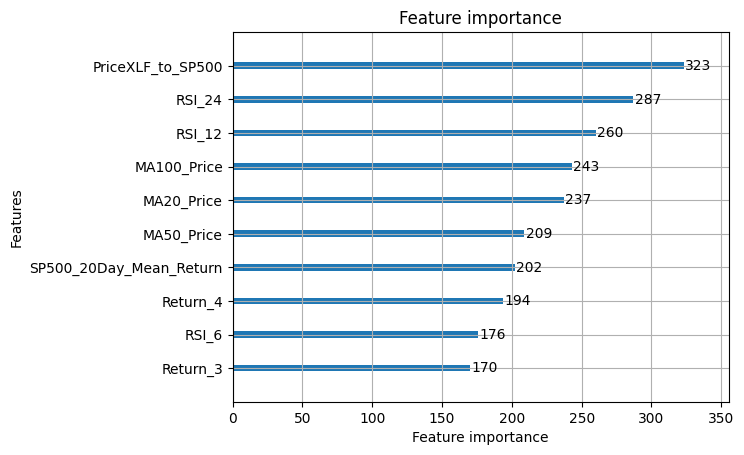

In [ ]:
future_return = data_etf['Adj Close'].pct_change(5).shift(-5)
df_features['Target'] = (future_return > 0).astype(int)

df_features = df_features.dropna()
X = df_features.drop(columns=['Target','PriceXLF','sp500price'])
y = df_features['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = lgb.LGBMClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")

lgb.plot_importance(clf, max_num_features=10)
plt.show()